In [1]:
# imports for opsim
import sqlite3
import astropy
from astropy.table import Table
import astropy.units as u

# imports needed to generate the Gaia reference catalog
import pandas as pd
import numpy as np
import lsst.daf.butler as dafButler
from lsst.daf.butler import Butler, Registry
from lsst.ts.wep.task.GenerateDonutCatalogOnlineTask import (
    GenerateDonutCatalogOnlineTask, 
    GenerateDonutCatalogOnlineTaskConfig,
)
from lsst.ts.wep.task.RefCatalogInterface import RefCatalogInterface
import lsst.geom
from lsst.afw.cameraGeom import Camera, Detector, PIXELS, FIELD_ANGLE, TAN_PIXELS
import lsst.pex.config as pexConfig
from typing import Union

# imports needed to simulate stars on the chips
import galsim
import batoid
import wfsim

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# stuff for additional magnitude cuts
from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.Utility import getConfigDir
from pathlib import Path

# catalog pruning
from sklearn.neighbors import NearestNeighbors

from lsst.meas.algorithms import ReferenceObjectLoader, LoadReferenceObjectsConfig

To Do:
- figure out how to store the Zernikes in the butler
- clean up the butler stuff. Need to save a donutStamps for each detector separately. Need to save a single Zernikes for each detector. Save the DOF too?
- need to split all this stuff out into python modules (I have an old donut simulation github repo I can put this in)
- write a script to run simulations and save in the butler. Do a short run and test the results.
- Fix the magLim stuff in GaiaSourceSelector (it is currently restricted to be fast for testing)
- Start setting few-day runs, and check back every day to make sure everything is working.

In [2]:
class ObsScheduler:
    """Select observations from the simulated observation scheduler."""
    
    _columns = {
        "observationID": "observationID",
        "fieldRA": "boresightRa", 
        "fieldDec": "boresightDec", 
        "rotTelPos": "boresightRotAng", 
        "filter": "lsstFilter", 
        "airmass": "airmass", 
        "seeingFwhm500": "seeingFwhm500", 
        "skyBrightness": "skyBrightness",
    }
    
    _units = {
        "boresightRa": u.deg, 
        "boresightDec": u.deg, 
        "boresightRotAng": u.deg,
        "seeingFwhm500": u.arcsec,
        "skyBrightness": u.mag("AB / arcsec**2"),
    }
    
    def __init__(
        self,
        opsim_path: str = "/astro/store/epyc/users/jfc20/rubin_sim_data/sim_baseline/baseline.db",
    ) -> None:
        """
        Parameters
        ----------
        opsim_path: str
            Path to the OpSim simulation database.
        """
        # read the observations from the sql database
        with sqlite3.connect(opsim_path) as conn:
            observations = pd.read_sql(f"select {', '.join(self._columns.keys())} from observations;", conn)
            
        # rename the columns
        observations = observations.rename(columns=self._columns)
        
        # convert to an Astropy table with units
        observations = Table.from_pandas(observations, units=self._units)
        
        # save the observations
        self.observations = observations
        
    def getRandomObservation(self, rng: np.random.Generator) -> astropy.table.Row:
        """Get a random observation from the database of observations.
        
        Parameters
        ----------
        rng: np.random.Generator
            A numpy random generator.
            
        Returns
        -------
        astropy.table.Row
            The random observation in an Astropy table.
        """
        idx = rng.integers(len(self.observations))
        return self.observations[idx]

In [3]:
class GaiaSourceSelector:
    """Select Gaia sources for Rubin imaging."""
    
    gaiaColumns = {
        "id": "objectId",
        "coord_ra": "ra",
        "coord_dec": "dec",
        "centroid_x": "xCentroid",
        "centroid_y": "yCentroid",
        "phot_g_mean_flux": "gaiaG",
        "phot_bp_mean_flux": "gaiaBp",
        "phot_rp_mean_flux": "gaiaRp",
    }
    
    def __init__(
        self, 
        butlerRepo: str = "/epyc/data/lsst_refcats/gen3",
        collections: list = ["refcats"],
        refCatName: str = "gaia_dr2_20200414",
        donutRadius: float = 75,
    ) -> None:
        """
        Parameters
        ----------
        butlerRepo: str, default="/epyc/data/lsst_refcats/gen3"
            Path to the butler repository.
        collections: list, default=["refcats"]
            The collections to be searched when loading the data.
        refCatName: str, default="gaia_dr2_20200414"
            Name of the reference catalog.
        donutRadius: float, default=75
            The donut radius used to determine whether donuts are blended.
        """
        # save the butler and collections
        self._butler = Butler(butlerRepo, collections=collections)
        
        # save the camera
        self._camera = self.butler.get(
            "camera", 
            dataId={"instrument":"LSSTCam"}, 
            collections=["LSSTCam/calib/unbounded"],
        )
        
        # save the reference catalog name
        self.refCatName = refCatName
        
        # and the donut radius used for AOS source selection
        self.donutRadius = donutRadius
        
        # load the Lsst r bandpass to use for magnitude conversions
        self._lsstRBand = galsim.Bandpass("LSST_r.dat", wave_type="nm").withZeropoint("AB")

    @property
    def butler(self) -> Butler:
        """Return the Butler."""
        return self._butler
    
    @property
    def camera(self) -> Camera:
        """Return the LSST Camera."""
        return self._camera
    
    def _getRefObjLoader(self, refCatInterface):
        """Return the reference object loader."""
        # get IDs of hierarchical triangular mesh (HTM) shards
        # covering the field of view
        htmIds = refCatInterface.getHtmIds()

        # get the data references and IDs for this pointing
        dataRefs, dataIds = refCatInterface.getDataRefs(
            htmIds, 
            self.butler, 
            self.refCatName, 
            self.butler.collections,
        )

        refObjLoader = ReferenceObjectLoader(
            dataIds=dataIds, 
            refCats=dataRefs, 
            config=LoadReferenceObjectsConfig(),
        )

        return refObjLoader
    
    def _removeBadFluxes(self, catalog: Table) -> Table:
        """Remove negative fluxes and NaNs from the catalog.
        
        nan_to_num maps NaNs to zero, so these are removed by the positivity cut.
        
        Parameters
        ----------
        catalog: astropy.table.Table
            Astropy table of the catalog.
            
        Returns
        -------
        astropy.table.Table
            The catalog with bad fluxes removed.
        """
        idx = np.where(
            (np.nan_to_num(catalog["gaiaG"]) > 0.0) &
            (np.nan_to_num(catalog["gaiaBp"]) > 0.0) &
            (np.nan_to_num(catalog["gaiaRp"]) > 0.0)
        )
        
        return catalog[idx]
    
    def _convertFluxesToLsstMag(self, catalog: Table, lsstFilter: str) -> Table:
        """Convert the catalog fluxes to the requested LSST filter.
        
        This works by converting Gaia magnitudes to an SDSS r band magnitude
        via the formula given in Table 5.7 here:
        https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/
            chap_cu5pho/sec_cu5pho_calibr/ssec_cu5pho_PhotTransf.html
            
        We assume SDSS r ~ LSST r, then use the SED for each star to translate
        the LSST r magnitude to other magnitudes.
        
        Parameters
        ----------
        catalog: astropy.table.Table
            Astropy table of the catalog.
        lsstFilter: str
            The name of the LSST filter for which the magnitude is calculated.
            Saved as `lsstMag`.
            
        Returns
        -------
        astropy.table.Table
            The new catalog with the flux columns replaced by `lsstMag`.
        """
        # first calculate SDSS r
        xGaia = (catalog["gaiaBp"].to(u.ABmag) - catalog["gaiaRp"].to(u.ABmag)).value
        gGaia = catalog["gaiaG"].to(u.ABmag).value
        rSdss = (
            + gGaia
            + 0.12879
            + -0.24662 * xGaia
            + 0.027464 * xGaia ** 2
            + 0.049465 * xGaia ** 3
        ) * u.ABmag
        
        # we will assume rLsst ~ rSdss
        rLsst = rSdss
        
        # convert to requested band
        if lsstFilter == "r":
            lsstMag = rLsst
        else:
            # list to hold the new magnitudes
            lsstMag = []
            # bandpass we are converting to
            bandpass = galsim.Bandpass(f"LSST_{lsstFilter}.dat", wave_type="nm").withZeropoint("AB")
            
            # use SEDs to calculate the magnitude in the requested band
            for r, T in zip(rLsst, catalog["temperature"]):
                sed = wfsim.BBSED(T).withMagnitude(r.value, self._lsstRBand)
                lsstMag.append(sed.calculateMagnitude(bandpass))
                
            # add the astropy unit for AB mags
            lsstMag *= u.ABmag
        
        # add the LSST magnitude to the catalog
        catalog["lsstMag"] = lsstMag
        
        # and remove the gaia magnitudes
        catalog.remove_columns(["gaiaG", "gaiaBp", "gaiaRp"])
        
        return catalog
    
    def _selectAosSources(self, catalog: Table, lsstFilter: str, detector: Detector) -> Table:
        """Select the AOS sources and remove donuts that do not blend with sources.
        
        Parameters
        ----------
        catalog: astropy.table.Table
            An astropy table representing the catalog.
        lsstFilter: str
            The LSST filter that magnitude cuts are performed in.
        detector: lsst.afw.cameraGeom.Detector
            The detector on which this catalog is imaged.
            
        Returns
        -------
            The catalog with AOS sources and blends flagged, and with extraneous
            donuts removed.
        """
        
        # load the AOS magnitude range for each band
        magLimPath = Path(getConfigDir()) / "task" / "magLimitStar.yaml"
        magLimFile = ParamReader(filePath=magLimPath)
        magLim = magLimFile.getSetting(f"filter{lsstFilter.upper()}")
        
        # make the source magnitude cut
        magCut = (catalog["lsstMag"] >= magLim["low"]) & (catalog["lsstMag"] <= magLim["high"]) 
        magCut = (catalog["lsstMag"] >= 18) & (catalog["lsstMag"] <= 20) 
        # select donuts that don't fall off the detector
        boundaryCut = detector.getBBox().erodedBy(int(1.25 * self.donutRadius)).contains(
            catalog["xCentroid"], catalog["yCentroid"]
        )
        
        # select donuts that are either isolated or the brightest in their blend
        xy = np.vstack((catalog["xCentroid"] , catalog["yCentroid"])).T
        xyNeigh = NearestNeighbors(radius=2 * self.donutRadius)
        xyNeigh.fit(xy)
        radDist, radIdx = xyNeigh.radius_neighbors(xy, sort_results=True)
        blendCut = []
        for neighbors in radIdx:
            mags = catalog["lsstMag"][neighbors]
            blendCut.append(all(mags[0] < mags[1:]))
        
        # sources that pass all of these cuts will be used for the AOS
        catalog["aosSource"] = magCut & boundaryCut & blendCut
        
        # label donuts that are blends with AOS sources
        blendId = -np.ones(len(catalog), dtype=int)
        if any(catalog["aosSource"]):
            # get overlaps with AOS sources
            radDist, radIdx = xyNeigh.radius_neighbors(xy[catalog["aosSource"] == True], sort_results=True)
            
            # create blendIds
            for neighbors in radIdx:
                if len(neighbors) > 1:
                    blendId[neighbors] = catalog["objectId"][neighbors[0]]
                    
        catalog["blendId"] = blendId
            
        # return only sources that are AOS sources or that blend with AOS sources
        return catalog[(catalog["aosSource"] == True) | (catalog["blendId"] > 0)]
    
    def selectSources(
        self,
        boresightRA: float,
        boresightDec: float,
        boresightRotAng: float,
        lsstFilter: str = "r",
        detectorNames: list = None,
        selectAosSources: bool = True,
        rng: np.random.Generator = None,
    ) -> Table:
        """Select source catalog corresponding to the given pointing.
        
        Parameters
        ----------
        boresightRA: float
            Right ascension (RA) of the telescope pointing in degrees.
        boresightDec: float
            Declination (Dec) of the telescope pointing in degrees.
        boresightRotAng: float
            Rotation angle of the telescope about the optical axis in degrees.
        lsstFilter: str, default="r"
            The LSST filter in which magnitudes are calculated.
        detectorNames: list, optional
            The list of detectors for which to generate the source catalog.
            If None, defaults to all corner wavefront sensors.
        selectAosSources: bool, default=True
            Whether to select the AOS sources and remove donuts that do not
            blend with these sources.
        rng: np.random.Generator, optional
            A numpy random number generator, used to simulate random temperatures
            for stars. If not provided, np.random.default_rng(0) is used.
        
        Returns
        -------
        astropy.table.Table
            An astropy table of the sources.
        """
        # if no rng is passed, use zero for the random seed
        rng = np.random.default_rng(0) if rng is None else rng
        
        # load the reference catalog interface for this pointing
        refCatInterface = RefCatalogInterface(boresightRA, boresightDec, boresightRotAng)
        
        # get the reference object loader
        refObjLoader = self._getRefObjLoader(refCatInterface)
        
        # if detectorName is None, get the default list
        if detectorNames is None:
            detectorNames = [f"R{i}_SW{j}" for i in ["00", "40", "44", "04"] for j in [0, 1]]
    
        # loop over the detectors and generate catalogs
        catalog = []
        for name in detectorNames:
            # load the detector
            detector = self.camera[name]

            # Get the refcatalog shard
            skyBox = refObjLoader.loadPixelBox(
                detector.getBBox(), 
                refCatInterface.getDetectorWcs(detector), 
                filterName="phot_g_mean", 
                bboxToSpherePadding=0
            )
            
            # get the catalog of stars
            cat = skyBox.refCat.asAstropy()
            
            # get the requested columns and rename them
            cat = cat[list(self.gaiaColumns.keys())]
            cat.rename_columns(
                list(self.gaiaColumns.keys()), 
                list(self.gaiaColumns.values()),
            )
            
            # remove bad fluxes
            cat = self._removeBadFluxes(cat)

            # random temperatures
            temperatures = rng.uniform(4_000, 10_000, size=len(cat))
            cat["temperature"] = temperatures
            cat["temperature"].unit = u.K
            
            # convert fluxes to LSST magnitude
            cat = self._convertFluxesToLsstMag(cat, lsstFilter)
            
            # select AOS sources
            if selectAosSources:
                cat = self._selectAosSources(cat, lsstFilter, detector)
            
            # if the catalog is empty, move on
            if len(cat) == 0:
                continue
            
            # save the detector name
            cat["detector"] = len(cat) * [name]
            
            # convert pixel numbers to field angles
            pixelPoints = [
                lsst.geom.Point2D(cenx, ceny) for cenx, ceny in zip(cat["xCentroid"], cat["yCentroid"])
            ]
            fieldAngles = np.array(self.camera.transform(pixelPoints, detector.makeCameraSys(PIXELS), FIELD_ANGLE))
            cat["xField"] = fieldAngles[:, 0]
            cat["yField"] = fieldAngles[:, 1]
            
            catalog.append(cat)
        
        # combine all catalogs into one
        catalog = astropy.table.vstack(catalog)
        
        # reorder the columns
        catalog = catalog[[
            "objectId", 
            "blendId", 
            "aosSource", 
            "ra", 
            "dec", 
            "xField", 
            "yField", 
            "xCentroid", 
            "yCentroid", 
            "detector", 
            "lsstMag", 
            "temperature"
        ]]
        
        return catalog

In [4]:
class ImageSimulator:
    """Simulate images on the Rubin focal plane from a catalog of stars."""
    
    rafts = ["R00", "R40", "R04", "R44"]
    extra_chips = [f"{raft}_SW0" for raft in rafts]
    intra_chips = [f"{raft}_SW1" for raft in rafts]
    
    # area of the Rubin primary mirror in cm^2
    m1Area = np.pi * 418 ** 2 * (1 - 0.61 ** 2)
    
    def __init__(
        self, 
        dof: np.ndarray,
        filterName: str,
        zenith:float,
        raw_seeing: float,
        expTime: float,
        temperature: float,
        pressure: float,
        H2O_pressure: float,
        screen_size: float,
        screen_scale: float,
        nproc: int,
        rng: np.random.Generator,
    ) -> None:
        """
        Parameters
        ----------
        dof: np.ndarray
            The degrees of freedom that perturb the telescope and mirror.
        filterName: str
            One of the LSST filters: u, g, r, i, z, y.
        zenith: galsim.Angle
            The zenith angle of the pointing. Sets the airmass.
        raw_seeing: galsim.Angle
            The zenith 500nm seeing in arcseconds.
        expTime: float
            The exposure time in seconds.
        temperature: float
            The temperature in Kelvin.
        pressure: float
            The air pressure in kPa.
        H2O_pressure: float
            The pressure of water in the air in kPa.
        screen_size: float
        screen_scale: float
        nproc: int
            The number of CPUs used to create screens in parallel.
        rng: np.random.Generator
            A numpy random generator.
        """
        # save the dofs, observation, and atmosphere params
        self._dof = dof
        self._obs_kwargs = {
            "zenith": zenith * galsim.degrees,
            "raw_seeing": raw_seeing * galsim.arcsec,
            "exptime": expTime,
            "temperature": temperature,
            "pressure": pressure,
            "H2O_pressure": H2O_pressure,
        }
        self._atm_kwargs = {
            "screen_size": screen_size,
            "screen_scale": screen_scale,
            "nproc": nproc,
        }
        
        # load the bandpass
        self._bandpass = galsim.Bandpass(f"LSST_{filterName}.dat", wave_type="nm").withZeropoint("AB")
        self._obs_kwargs["wavelength"] = self._bandpass.effective_wavelength
        
        # load the telescope
        telescope = batoid.Optic.fromYaml(f"LSST_{filterName}.yaml")
        
        # perturb the telescope
        factory = wfsim.SSTFactory(telescope)
        self._telescope = factory.get_telescope(dof=dof)
        
        # create the simulator
        self._simulator = wfsim.SimpleSimulator(
            self._obs_kwargs,
            self._atm_kwargs,
            self._telescope,
            self._bandpass,
            rng=rng,
        )
        
    @property
    def dof(self) -> np.ndarray:
        """Return the telescope perturbations."""
        return self._dof
    
    @property
    def bandpass(self) -> galsim.Bandpass:
        """Return the bandpass."""
        return self._bandpass
    
    @property
    def obs_kwargs(self) -> dict:
        """Return the observation params."""
        return self._obs_kwargs
    
    @property
    def atm_kwargs(self) -> dict:
        """Return the atmosphere params."""
        return self._atm_kwargs
    
    def getSimulator(self, chip: str) -> wfsim.SimpleSimulator:
        """Return the simulator for the corresponding chip.
        
        Parameters
        ----------
        chip: str
            The name of the chip you want the simulator for.
        
        Returns
        -------
        wfsim.SimpleSimulator
            The wfsim simulator for the chip requested.
        """
        # load the current simulator and telescope
        simulator = self._simulator
        telescope = self._telescope
        
        # set the focal distance of the telescope
        if chip in self.extra_chips:
            simulator.telescope = telescope.withGloballyShiftedOptic("Detector", [0, 0, +0.0015])
        elif chip in self.intra_chips:
            simulator.telescope = telescope.withGloballyShiftedOptic("Detector", [0, 0, -0.0015])
        else:
            simulator.telescope = telescope.withGloballyShiftedOptic("Detector", [0, 0, 0])
            
        # set the name of the simulator to the chip name
        # this sets the location, size, and orientation of the chip
        simulator.set_name(chip)
        
        return simulator
    
    def _correctCentroids(self, catalog: Table) -> Table:
        """Correct the centroids so they correspond to donut centers from batoid.
        
        I believe this is because LSST uses a tangent projection which distorts
        positions far from the center of the focal plane.
        
        Parameters
        ----------
        catalog: astropy.table.Table
            The catalog of stars whose centroids need correction.
            
        Returns
        -------
        astropy.table.Table
            The catalog with corrected centroids.
        """        
        # don't modify original
        catalog = catalog.copy()
        
        for detector in set(catalog["detector"]):
            # get the simulator for this detector
            simulator = self.getSimulator(detector)
            
            # convert the field angles to pixels
            xCentroid, yCentroid = simulator.wcs.radecToxy(
                catalog[catalog["detector"] == detector]["xField"], 
                catalog[catalog["detector"] == detector]["yField"], 
                galsim.radians,
            )
            
            # shift coordinate system to bottom left of image
            xCentroid -= simulator.image.bounds.xmin
            yCentroid -= simulator.image.bounds.ymin
            
            # convert these pixels to pixels in the LSST coordinate system
            # https://github.com/jmeyers314/wfsim/blob/main/notebooks/
            #     Focal%20Plane%20Coordinate%20Systems.ipynb
            if detector in ["R00_SW0", "R44_SW1"]:
                xCentroid, yCentroid = 4072 - xCentroid, 2000 - yCentroid
            elif detector in ["R40_SW0", "R04_SW1"]:
                xCentroid, yCentroid = yCentroid, 2000 - xCentroid
            elif detector in ["R40_SW1", "R04_SW0"]:
                xCentroid, yCentroid = 4072 - yCentroid, xCentroid
            elif detector in ["R00_SW1", "R44_SW0"]:
                pass
            
            # save the new centroids
            catalog["xCentroid"][catalog["detector"] == detector] = xCentroid
            catalog["yCentroid"][catalog["detector"] == detector] = yCentroid
            
        return catalog
    
    def cutoutStamps(self, images: dict, catalog: Table, cropRadius: int = 80) -> dict:
        """Cutout the individual donut stamps.
        
        Parameters
        ----------
        images: dict
            Dictionary of CWFS images.
        catalog: astropy.table.Table
            The catalog of stars in the CWFS images.
        
        Returns
        -------
        dict
            A dictionary of donut postage stamps.
        """
        
        # get the corrected centroids
        catalog = self._correctCentroids(catalog)
    
        stamps = dict()
        for cat in catalog.group_by("detector").groups:
            # get the detector name
            detector = cat["detector"][0]

            # get the AOS sources
            if "aosSource" in cat.columns:
                cat = cat[cat["aosSource"] == True]
              
            # if the catalog is empty, move on
            if len(cat) == 0:
                continue

            # get the centroid pixels of the donuts
            xCentroid = cat["xCentroid"].value.round().astype(int)
            yCentroid = cat["yCentroid"].value.round().astype(int)

            # convert the LSST pixels coords into the numpy pixel coords
            # note this assumes that you are NOT simulating on guide sensors
            if detector in ["R00_SW0", "R44_SW1"]:
                xCentroid, yCentroid = 4072 - xCentroid, 2000 - yCentroid
            elif detector in ["R40_SW0", "R04_SW1"]:
                xCentroid, yCentroid = 2000 - yCentroid, xCentroid
            elif detector in ["R40_SW1", "R04_SW0"]:
                xCentroid, yCentroid = yCentroid, 4072 - xCentroid
            elif detector in ["R00_SW1", "R44_SW0"]:
                pass

            # get the image for this detector
            img = images[detector]

            # crop the donuts
            for ID, x, y in zip(cat["objectId"], xCentroid, yCentroid):
                stamps[ID] = img[
                    max(y-cropRadius, 0): min(y+cropRadius, img.shape[0]),
                    max(x-cropRadius, 0): min(x+cropRadius, img.shape[1])
                ].copy()

        return stamps
            
    def simulateCatalog(
        self, 
        catalog: Table, 
        rng: np.random.Generator, 
        background: bool = None, 
        returnStamps: bool = True,
        cropRadius: int = 85,
    ) -> dict:
        """Simulate CWFS images for the given catalog.
        
        Parameters
        ----------
        catalog: Table
            The catalog of stars to simulate.
        rng: np.random.Generator
            A numpy random generator.
        background: float, optional
            The sky brightness in ABmag / arcsec^2.
            If None, no background is simulated.
        returnStamps: bool, default=True
            Whether to return donut stamps instead of the full CWFS images.
        cropRadius: int, default=85
            The radius (half the width) of the cutout postage stamps.
            
        Returns
        -------
        dict
            Dictionary of the form {chip_name: simulated_image}
        """
        # get the list of detectors
        detectors = set(catalog["detector"])
        
        # if we are simulating the sky background, get the photon flux
        if background is not None:
            skySed = galsim.SED(lambda x: 1, "nm", "flambda").withMagnitude(background, self.bandpass)
            skyFlux = skySed.calculateFlux(self.bandpass) # photons / cm^2 / s / arcsec^2
            nSkyPhotons = skyFlux * self._obs_kwargs["exptime"] * self.m1Area # photons / arcsec^2
            
        # loop through the detectors
        images = {}
        for detector in detectors:
            # get the simulator for this detector
            simulator = self.getSimulator(detector)
            
            # simulate stars on this detector
            for star in catalog[catalog["detector"] == detector]:
                sed = wfsim.BBSED(star["temperature"]).withMagnitude(star["lsstMag"], self.bandpass)
                nPhotons = int(sed.calculateFlux(self.bandpass) * self._obs_kwargs["exptime"] * self.m1Area)
                simulator.add_star(star["xField"], star["yField"], sed, nPhotons, rng)
                
            # add background
            if background is not None:
                sqArcsecPerPixel = np.prod(np.diff(simulator.get_bounds(galsim.arcsec), axis=1)) / simulator.image.array.size
                simulator.add_background(nSkyPhotons * sqArcsecPerPixel, rng)
                
            # save the detector image in the dictionary
            images[detector] = simulator.image.array.copy()
            
        # cutout the individual donut stamps
        if returnStamps:
            images = self.cutoutStamps(images, catalog, cropRadius)
        
        return images

In [5]:
class CwfsSimulator:
    """Simulate Observations on the corner wavefront sensors."""
    def __init__(
        self, 
        opsim_path: str = "/astro/store/epyc/users/jfc20/rubin_sim_data/sim_baseline/baseline.db",
    ) -> None:
        """
        Parameters
        ----------
        opsim_path: str
            Path to the OpSim simulation database.
        """
        # create the Observation Scheduler
        self.obsScheduler = ObsScheduler(opsim_path)
        
        # create the Source Selector
        self.sourceSelector = GaiaSourceSelector()
        
    def simulateObs(
        self, 
        dof: np.ndarray,
        seed: int,
        expTime: float = 15,
        temperature: float = 293,
        pressure: float = 69,
        H2O_pressure: float = 1,
        screen_size: float = 819.2,
        screen_scale: float = 0.1,
        nproc: int = 6,
        background: bool = True,
        returnStamps: bool = True,
        cropRadius: int = 85,
    ) -> dict:
        """
        Parameters
        ----------
        dof: np.ndarray
            The degrees of freedom that perturb the telescope and mirror.
        seed: int
            A number to set the random seed.
        expTime: int
            The exposure time in seconds.
        temperature: float, default=293
            The temperature in Kelvin.
        pressure: float, default=69
            The air pressure in kPa.
        H2O_pressure: float, default=1
            The pressure of water in the air in kPa.
        screen_size: float, default=819.2
        screen_scale: float, default=0.1
        nproc: int, default=6
            The number of CPUs used to create screens in parallel.
        background: bool, default=True
            Whether to simulate the sky background.
        returnStamps: bool, default=True
            Whether to return donut stamps instead of the full CWFS images.
        cropRadius: int, default=85
            The radius (half the width) of the cutout postage stamps.
        
        Returns
        -------
        dict
            Dictionary containing metadata and the images.
        """
        # create the rng
        rng = np.random.default_rng(seed)
        
        # get a random observation
        observation = self.obsScheduler.getRandomObservation(rng)
        
        # get a catalog from the pointing
        catalog = self.sourceSelector.selectSources(
            observation["boresightRa"],
            observation["boresightDec"],
            observation["boresightRotAng"],
            lsstFilter=observation["lsstFilter"],
            selectAosSources=True,
            rng=rng,
        )
        
        # add observation IDs to match stars to the opsim ID
        catalog.add_column(len(catalog) * [observation["observationId"]], 0, "observationId")

        # build the image simulator
        simulator = ImageSimulator(
            dof=dof,
            filterName=observation["lsstFilter"],
            zenith=np.arccos(1 / observation["airmass"]),
            raw_seeing=observation["seeingFwhm500"],
            expTime=expTime,
            temperature=temperature,
            pressure=pressure,
            H2O_pressure=H2O_pressure,
            screen_size=screen_size,
            screen_scale=screen_scale,
            nproc=nproc,
            rng=rng,
        )
        
        # set the sky background
        background = observation["skyBrightness"] if background else None
        
        # simulate the images
        images = simulator.simulateCatalog(catalog, rng, background, returnStamps, cropRadius)
        
        # correct the centroids
        catalog = simulator._correctCentroids(catalog)
        
        return {
            "metadata": observation,
            "catalog": catalog,
            "images": images,
        }

In [6]:
def plotCwfs(images: dict, vmax=None) -> plt.Figure:
    """Plot the CWFS images.
    
    Parameters
    ----------
    images: dict
        The dictionary of CWFS images. Format is 
        {`chip_name`: np.ndarray}.
        
    Returns
    -------
    plt.Figure
        Figure of the images.
    """
    
    # create the figure
    fig = plt.figure(figsize=(6,6), dpi=120, constrained_layout=True)

    # create the grid of detectors
    gs = GridSpec(4, 4, figure=fig)
    axes = {
        "R40_SW1": fig.add_subplot(gs[:2, 0]),
        "R40_SW0": fig.add_subplot(gs[:2, 1]),
        "R44_SW1": fig.add_subplot(gs[0, -2:]),
        "R44_SW0": fig.add_subplot(gs[1, -2:]),
        "R00_SW0": fig.add_subplot(gs[2, :2]),
        "R00_SW1": fig.add_subplot(gs[3, :2]),
        "R04_SW0": fig.add_subplot(gs[-2:, 2]),
        "R04_SW1": fig.add_subplot(gs[-2:, 3]),
    }
    
    # plot the available detectors
    for chip, img in images.items():
        axes[chip].imshow(img, origin="lower", vmax=vmax)
    
    # remove all the tickmarks
    for ax in axes.values():
        ax.set(xticks=[], yticks=[])
    
    return fig

In [7]:
def plotStamps(stamps: dict) -> plt.Figure:
    """Plot the donut postage stamps.
    
    Parameters
    ----------
    stamps: dict
        The dictionary of donut postage stamps.
        
    Returns
    -------
    plt.Figure
        Figure of the images.
    """
    # create the figure with the correct number of rows
    nrows = np.ceil(len(stamps.values()) / 10).astype(int)
    fig, axes = plt.subplots(nrows, 10, figsize=(16, 1.6 * nrows), constrained_layout=True)

    # plot all the stamps
    for i, img in enumerate(stamps.values()):
        ax = axes.flatten()[i]
        ax.imshow(img, origin="lower")
        ax.set(xticks=[], yticks=[], title=i)

    # remove empty frames
    for ax in axes.flatten()[i+1:]:
        ax.remove()

In [8]:
%%time
# set the rng
rng = np.random.default_rng(42)

# random degrees of freedom to perturb the telescope
dof = rng.normal(scale=0.1, size=50)

cwfsSimulator = CwfsSimulator()
observation = cwfsSimulator.simulateObs(dof, rng, background=False)

CPU times: user 9min 59s, sys: 4min 18s, total: 14min 17s
Wall time: 48.6 s


In [9]:
observation["metadata"]

observationId,boresightRa,boresightDec,boresightRotAng,lsstFilter,airmass,seeingFwhm500,skyBrightness
,deg,deg,deg,,,arcsec,mag(AB / arcsec2)
int64,float64,float64,float64,str1,float64,float64,float64
1658826,9.24202850181174,-44.503236552113265,47.769890821417334,r,1.049825811752074,0.582773528821838,21.13954481867086


In [10]:
observation["catalog"]

observationId,objectId,blendId,aosSource,ra,dec,xField,yField,xCentroid,yCentroid,detector,lsstMag,temperature
,,,,rad,rad,,,,,,mag(AB),K
int64,int64,int64,bool,float64,float64,float64,float64,float64,float64,str7,float64,float64
1658826,4978991522798935552,4978991896460361984,False,0.15912416825029158,-0.8045340691944298,-0.01957895671402302,-0.019813953226363715,801.6627350165763,1170.2812346842438,R00_SW0,21.062533652760475,4687.180441215841
1658826,4978987704572269056,-1,True,0.16048077292755006,-0.805374631627287,-0.020833941763499796,-0.019681472717929253,2096.651913921396,1034.5801908338908,R00_SW0,19.904849361963254,8010.41777074283
1658826,4978991552862976256,-1,True,0.15843128220761318,-0.8047612919535093,-0.01942523059720899,-0.02032295025321933,643.4403325854801,1695.4138869205053,R00_SW0,19.804226028313376,7355.242964472482
1658826,4978991896460361984,4978991896460361984,True,0.15926389011063807,-0.8046178632782126,-0.019706167534763015,-0.01979835794210844,932.9186937698069,1154.2879885129769,R00_SW0,19.615730512116517,5287.508036917176
1658826,4978992789813569152,4978992828469973504,False,0.15935382921784622,-0.803791822403119,-0.019135167274457764,-0.01919733027918343,343.26389561162796,533.6713653658626,R00_SW0,20.34293255051935,4349.816450134396
1658826,4978987640149443584,4978987640149443584,True,0.16036578895204257,-0.8058487172763489,-0.02113195335462535,-0.02005919208369428,2404.5397613055975,1424.627804376265,R00_SW0,18.79066025205895,7971.49908836137
...,...,...,...,...,...,...,...,...,...,...,...,...
1658826,4992295196881703424,-1,True,0.11994521027119097,-0.772772553297009,0.022517787556313975,-0.019558540520849356,3268.507020174864,342.49108881795837,R04_SW1,19.696264528677684,5902.919026779873


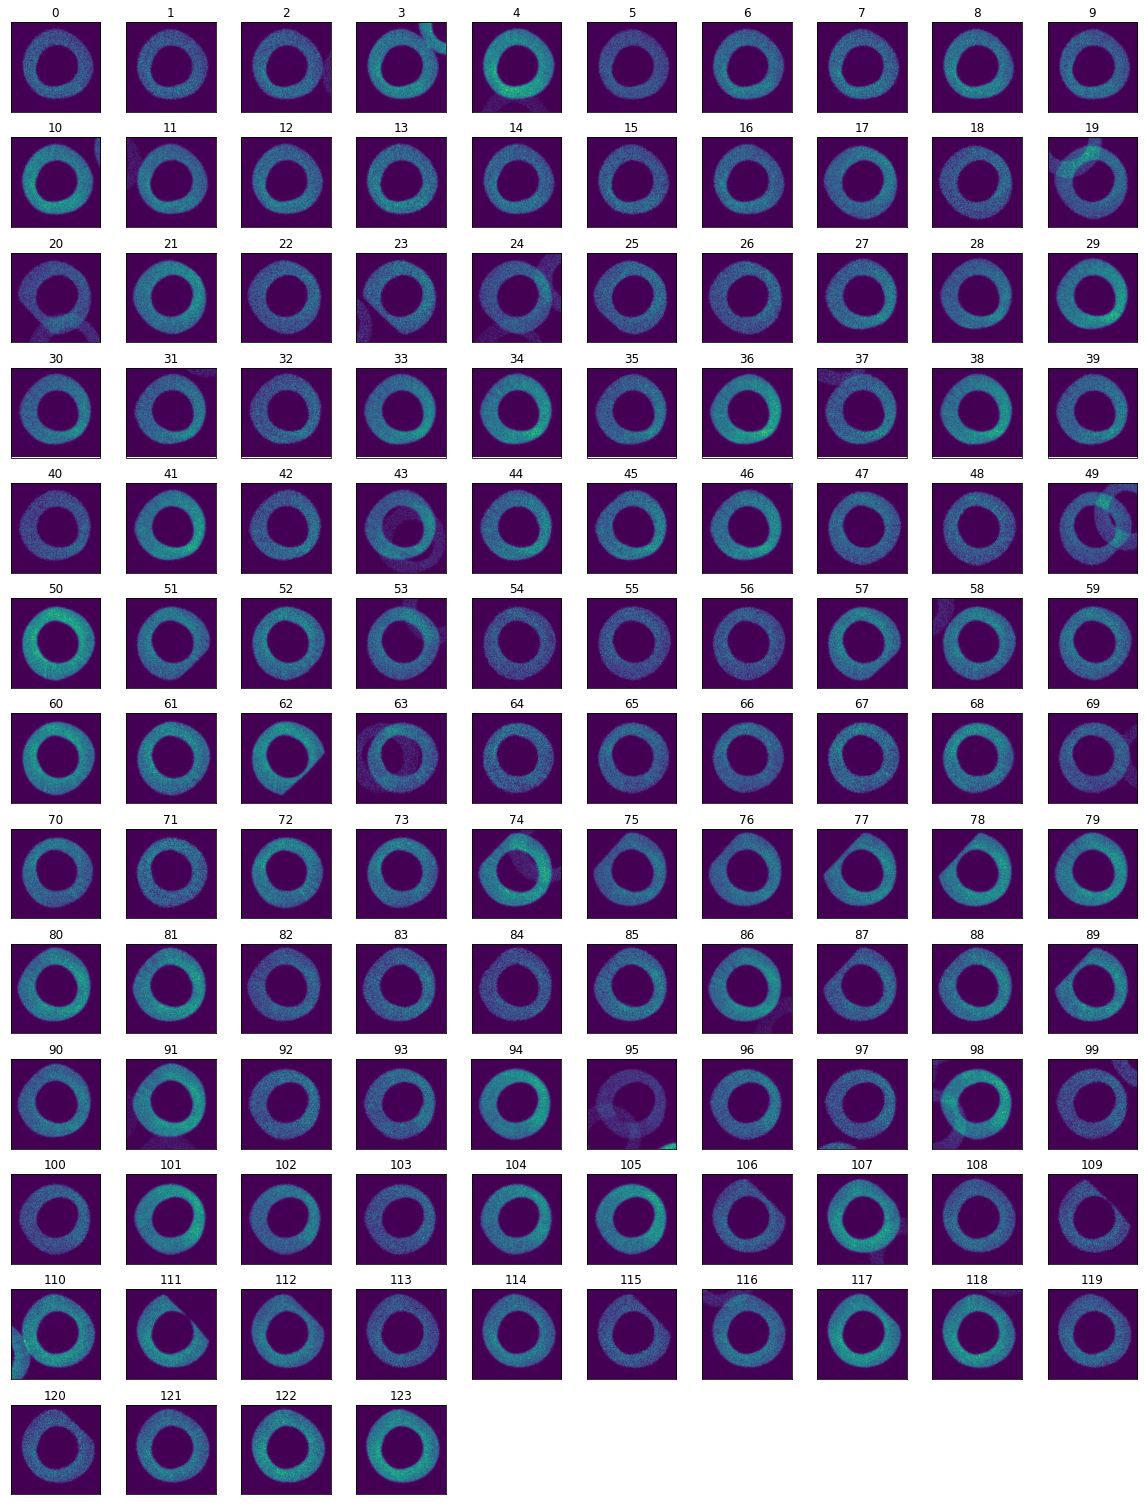

In [11]:
plotStamps(observation["images"]);

In [12]:
import lsst.afw.image as afwImage
from lsst.ts.wep.task.DonutStamp import DonutStamp
from lsst.ts.wep.task.DonutStamps import DonutStamps
from lsst.ts.wep.Utility import CamType, DefocalType, getConfigDir, getModulePath

In [118]:
class StampsToButler:
    """Save stamps and the corresponding zernikes in the butler."""
    
    detectorNumbers = {
        "R00_SW0": 191,
        "R00_SW1": 190,
        "R40_SW0": 199,
        "R40_SW1": 200,
        "R04_SW0": 195,
        "R04_SW1": 194,
        "R44_SW0": 203,
        "R44_SW1": 204,
    }
    
    detectorLocations = {
        "R00_SW0": (-0.02075, -0.02075),
        "R00_SW1": (-0.02075, -0.02075),
        "R40_SW0": (-0.02075, +0.02075),
        "R40_SW1": (-0.02075, +0.02075),
        "R04_SW0": (+0.02075, -0.02075),
        "R04_SW1": (+0.02075, -0.02075),
        "R44_SW0": (+0.02075, +0.02075),
        "R44_SW1": (+0.02075, +0.02075),
    }
    
    def __init__(self) -> None:
        wepExampleRepo = Path(getModulePath()) / "tests" / "testData" / "gen3TestRepo"
        self._butler = Butler(wepExampleRepo, writeable=True)
        self.butler.registry.registerRun('mlStamps')
    
    @property
    def butler(self) -> Butler:
        """Return the Butler."""
        return self._butler
    
    @property
    def registry(self) -> Registry:
        """Return the Registry."""
        return self.butler.registry
    
    def wrapStamps(self, stamps: dict, catalog: Table) -> dict:
        """Wrap the donut stamps in the DonutStamps class.
        
        Parameters
        ----------
        stamps: dict
            The dictionary of postage stamps.
        catalog: astropy.table.Table
            Astropy table of the catalog corresponding to the postage stamps.
        
        Returns
        -------
        dict
            A dictionary of DonutStamps objects.
        """
        sources = catalog[catalog["aosSource"] == True]
        
        donutStamps = {}
        for cat in sources.group_by("detector").groups:
            # get the detector name
            detector = cat["detector"][0]
            
            # get the defocal type
            if detector[-1] == "0":
                defocalType = DefocalType.Extra
            elif detector[-1] == "1":
                defocalType = DefocalType.Intra
                
            donutStamps[detector] = []
            for star in cat:
                
                # put the stamp in an afw masked image
                maskedImage = afwImage.MaskedImageF(
                       image=afwImage.ImageF(stamps[star["objectId"]])
                )
                
                # save the stamp as a DonutStamp
                donutStamps[detector].append(
                    DonutStamp(
                        maskedImage,
                        lsst.geom.SpherePoint(star["ra"], star["dec"], lsst.geom.radians),
                        lsst.geom.Point2D(star["xCentroid"], star["yCentroid"]),
                        defocalType,
                        detector,
                        "LSSTCam",
                    )
                )
            
            # wrap the list in the DonutStamps class
            donutStamps[detector] = DonutStamps(donutStamps[detector])
        
        return donutStamps
    
    def calculateZernikes(self, detector: str, dof: np.ndarray, band: str = "r") -> np.ndarray:
        """Calculate zernikes for the detector given the perturbations.
        
        Note the zernikes are calculated at the center of the CWFS.
        So for example, if detector == "R00_SW0", then the zernikes
        are calculated at the center of R00_SW0 U R00_SW1.
        
        The Noll indices of zernikes returned are 4-22.
        
        Parameters
        ----------
        detector: str
            The name of the detector to calculate zernikes for.
        dof: np.ndarray
            The degrees of freedom used to perturb the telescope.
        band: str, default="r"
            The name of the band the images are observed in.
            
        Returns
        -------
        np.ndarray
            The array of zernikes for the detector, with Noll indixes 4-22.
        """
        # get the location where we calculate zernikes
        location = self.detectorLocations[detector]
        
        # perturb the telescope
        bandpass = galsim.Bandpass(f"LSST_{band}.dat", wave_type="nm")
        telescope = batoid.Optic.fromYaml(f"LSST_{band}.yaml")
        factory = wfsim.SSTFactory(telescope)
        perturbed_telescope = factory.get_telescope(dof=dof)
        
        # calculate the zernikes
        zernikes = batoid.zernike(
            perturbed_telescope, 
            location[0], location[1],
            bandpass.effective_wavelength*1e-9, # nm -> m
            jmax=22,
        )

        return zernikes
    
    def saveSimulation(
        self, 
        stamps: dict, 
        catalog: astropy.table.Table, 
        metadata: astropy.table.Table,
        dof: np.ndarray,
    ) -> None:
        """Save the donut simulations and the corresponding zernikes in the butler.
        
        Parameters
        ----------
        stamps: dict
            The dictionary of donuts {objectId: postage stamp}.
        catalog: astropy.table.Table
            The astropy table of the catalog of stars.
        metadata: astropy.table.Row
            The astropy row containing metadata from the OpSim.
        dof: np.ndarray
            The degrees of freedom that were used to perturb the telescope.
        """
        # get the observation ID
        observationId = int(metadata["observationId"])
        
        # and bandpass
        band = metadata["lsstFilter"]
        
        # save the metadata
        self.registry.insertDimensionData(
            "visit",
            {
                "name": "seed=0",
                "visit": observationId,
                "instrument": "LSSTCam",
                "physical_filter": band,
            }
        )
        
        # wrap stamps in the DonutStamps object
        donutStamps = self.wrapStamps(stamps, catalog)
        
        # loop through the detectors
        for detector, dS in donutStamps.items():
            
            # get the dataset type
            if detector[-1] == "0":
                donutStampsDatasetType = self.registry.getDatasetType("donutStampsExtra")
            if detector[-1] == "1":
                donutStampsDatasetType = self.registry.getDatasetType("donutStampsIntra")
                
            # create the data reference
            dRef = dafButler.DatasetRef(
                donutStampsDatasetType, 
                dataId={
                    "visit": observationId, 
                    "detector": self.detectorNumbers[detector],
                    "instrument": "LSSTCam",
                }
            )
            
            # save the stamps in the butler
            self.butler.put(dS, dRef, run="mlStamps")

            # calculate zernikes
            zernikes = self.calculateZernikes(detector, dof, band)
            
            # create the data reference
            dRef = dafButler.DatasetRef(
                self.registry.getDatasetType("zernikeEstimateAvg"), 
                dataId={
                    "visit": observationId,
                    "detector": self.detectorNumbers[detector],
                    "instrument": "LSSTCam",
                }
            )

            # save the zernikes in the butler
            self.butler.put(zernikes, dRef, run="mlStamps")

In [119]:
stb = StampsToButler()
stb.saveSimulation(observation["images"], observation["catalog"], observation["metadata"], dof)

In [120]:
list(stb.butler.registry.queryDataIds('visit', datasets='donutStampsExtra', collections='mlStamps'))

[{instrument: 'LSSTCam', visit: 1658826, ...},
 {instrument: 'LSSTCam', visit: 1658826, ...},
 {instrument: 'LSSTCam', visit: 1658826, ...},
 {instrument: 'LSSTCam', visit: 1658826, ...}]

In [93]:
for _ in x:
    print(_.to_json())

{"dataId": {"band": "r", "instrument": "LSSTCam", "physical_filter": "r", "visit_system": null, "visit": 1658826}}
{"dataId": {"band": "r", "instrument": "LSSTCam", "physical_filter": "r", "visit_system": null, "visit": 1658826}}
{"dataId": {"band": "r", "instrument": "LSSTCam", "physical_filter": "r", "visit_system": null, "visit": 1658826}}
{"dataId": {"band": "r", "instrument": "LSSTCam", "physical_filter": "r", "visit_system": null, "visit": 1658826}}


In [115]:
d = {"instrument": "LSSTCam", "physical_filter": "r", "visit": 1658826, "detector": 191}

In [116]:
stb.butler.get('zernikeEstimateAvg', dataId=d, collections='mlStamps')

array([ 0.        ,  4.18753133,  1.15209175,  2.19451059, -0.32955982,
       -0.33311893,  0.11428408, -0.75592241, -0.34965321,  0.39869288,
        0.10065425, -0.27682338,  0.00806142, -0.02599517, -0.07765457,
        0.09160409,  0.21929835,  0.20039409, -0.12673102,  0.01244307,
        0.21650508, -0.18272696, -0.01431865])

In [77]:
x.get(d"donutStampsExtra")

In [83]:
dir(x)

['__abstractmethods__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_abc_impl',
 '_graph',
 '_is_protocol',
 '_record',
 '_serializedType',
 '_values',
 'byName',
 'expanded',
 'fromFullValues',
 'fromRequiredValues',
 'from_json',
 'from_simple',
 'full',
 'get',
 'graph',
 'hasFull',
 'hasRecords',
 'items',
 'keys',
 'makeEmpty',
 'names',
 'pack',
 'records',
 'region',
 'standardize',
 'subset',
 'timespan',
 'to_json',
 'to_simple',
 'union',
 'universe',
 'values']

In [84]:
x.to_json()

'{"dataId": {"band": "r", "instrument": "LSSTCam", "physical_filter": "r", "visit_system": null, "visit": 1658826}}'

In [85]:
x["dataId"]

KeyError: 'dataId'

In [86]:
x

{instrument: 'LSSTCam', visit: 1658826, ...}

In [131]:
for c in stb.registry.queryDatasetTypes():
    print(c)

DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('cal_ref_cat', {htm7}, SimpleCatalog)
DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
DatasetType('generateDonutCatalogOnlineTask_metadata', {instrument}, PropertySet)
DatasetType('isr_config', {}, Config)
DatasetType('generateDonutCatalogOnlineTask_config', {}, Config)
DatasetType('packages', {}, Packages)
DatasetType('generateDonutCatalogWcsTask_config', {}, Config)
DatasetType('donutCatalog', {band, instrument, detector, physical_filter, visit_system, visit}, DataFrame)
DatasetType('isr_log', {band, instrument, detector, physical_filter, exposure}, ButlerLogRecords)
DatasetType('generateDonutCatalogWcsTask_metadata', {band, instrument, detector, physical_filter, visit_system, visit},

In [129]:
#datasetRefs =
list(stb.registry.queryDatasets(datasetType="zernikeEstimateAvg", collections=["mlStamps"]))[0].to_json()

'{"id": 23, "datasetType": {"name": "zernikeEstimateAvg", "storageClass": "NumpyArray", "dimensions": {"names": ["band", "instrument", "detector", "physical_filter", "visit_system", "visit"]}}, "dataId": {"dataId": {"band": "r", "instrument": "LSSTCam", "detector": 191, "physical_filter": "r", "visit_system": null, "visit": 1658826}}, "run": "mlStamps"}'